In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from ast import literal_eval
import time
from datetime import timedelta
import pickle

from scipy.sparse import hstack, vstack, csr_matrix, load_npz, save_npz

pd.set_option('display.width', 1400)

In [2]:
# NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

STOPWORDS = list(nltk.corpus.stopwords.words('english'))
STEMMER = nltk.stem.snowball.SnowballStemmer('english')
LEMMATIZER = nltk.stem.WordNetLemmatizer()

def text_preprocessor(document):
    tokens = []
    for sentence in sent_tokenize(document.lower()):
        words = word_tokenize(sentence)
        words = [ word for word in words if (word.isalpha() and word not in STOPWORDS) ]
        words = [ STEMMER.stem(word) for word in words ]
        words = [ LEMMATIZER.lemmatize(word, pos="v") for word in words ]
        tokens.extend(words)
    return ' '.join(tokens)

#### Functions

In [3]:
def get_train_and_test_data(df):
    from sklearn.model_selection import train_test_split
    df_exploded = df.explode(['rated_recipes', 'rating_list'])
    df_train_exploded, df_test_exploded = train_test_split(df_exploded, test_size=0.2, random_state=42)
    df_train = df_train_exploded.groupby(level=0).agg(list).drop('ingredients', axis=1)
    df_test = df_test_exploded.groupby(level=0).agg(list).drop('ingredients', axis=1)
    all_user_ids = df.index
    df_train = df_train.reindex(all_user_ids, fill_value=[]) # Re-index to ensure all user_ids are included
    df_test = df_test.reindex(all_user_ids, fill_value=[])
    return df_train, df_test

In [4]:
def format_text(text, line_width=120):
    lines = []
    line = ''
    for word in text.split():
        if len(line) == 0:
            line = word
        elif len(line + ' ' + word) > line_width:
            lines.append(line)
            line = ''
        else:
            line += ' ' + word
    lines.append(line)
    return '\n'.join(lines)

#### Load Dataframes

In [10]:
# Load recipes & recipe_reviews
converters = { k: literal_eval for k in ['tags', 'ingredients', 'steps', 'nutrition'] } # for evaluating strings as arrays (eg. tags)
df_recipes = pd.read_csv('dataset/RAW_recipes.csv', converters=converters, index_col='id')
df_recipe_reviews = pd.read_csv('dataset/Recipe_Reviews.csv', index_col='id')
# df_interact = pd.read_csv('dataset/RAW_interactions.csv', dtype={'review': str})

# converters = { k: literal_eval for k in ['rated_recipes', 'ingredients', 'rating_list'] }
# df_userdata = pd.read_csv('dataset/User_Data.csv', converters=converters, index_col='user_id')

In [5]:
# Create/Load Training and Test data
converters = { k: literal_eval for k in ['rated_recipes', 'ingredients', 'rating_list'] }
train_fn = 'dataset/User_Data_Train.csv'
test_fn = 'dataset/User_Data_Test.csv'
if os.path.exists(train_fn):
    print('Loading train and test userdata ...')
    df_train = pd.read_csv(train_fn, converters=converters, index_col='user_id')
    df_test =  pd.read_csv(test_fn, converters=converters, index_col='user_id')
else:
    print('Reading userdata dataframe ...')
    df_userdata = pd.read_csv('dataset/User_Data.csv', converters=converters, index_col='user_id')
    print('Splitting userdata into training and test data ...')
    df_train, df_test = get_train_and_test_data(df_userdata.head(None).copy())
    df_train.to_csv(train_fn)
    df_test.to_csv(test_fn)
print('Done.')

Loading train and test userdata ...
Done.


#### TF-IDF Functions

In [6]:
# Generate combined TFIDF matrix based on tags&ingredients, descriptions, and user reviews
def create_tfidf_matrix(df_recipes: pd.DataFrame, df_recipe_reviews: pd.DataFrame, size_limit=None):
    recipes_dataframe = df_recipes.head(size_limit).copy()
    recipe_reviews_dataframe = df_recipe_reviews.head(size_limit).copy()

    # Generate TFIDF matrix on tags and ingredients
    print('Generating keywords TFIDF model ... ', end='')
    start = time.time()
    tags_corpus = [ ' '.join(x).replace('-', '') for x in recipes_dataframe['tags'].values ]
    ingr_corpus = [ ' '.join(x)                  for x in recipes_dataframe['ingredients'].values ]
    keywords_corpus = [ f'{tag} {ing}' for tag, ing in zip(tags_corpus, ingr_corpus) ]
    keywords_tfidf = TfidfVectorizer()
    keywords_tfidf_matrix = keywords_tfidf.fit_transform(keywords_corpus)
    print('took {}'.format( str(timedelta(seconds=(time.time()-start)))[:-3] ))

    # Generate TFIDF matrix on recipe descriptions
    print('Generating descriptions TFIDF model ... ', end='')
    start = time.time()
    descriptions_corpus = list(recipes_dataframe['description'].fillna('').values)
    desc_tfidf = TfidfVectorizer(preprocessor=text_preprocessor, ngram_range=(1, 2))
    desc_tfidf_matrix = desc_tfidf.fit_transform(descriptions_corpus)
    print('took {}'.format( str(timedelta(seconds=(time.time()-start)))[:-3] ))

    # Generate TFIDF matrix on recipe reviews
    print('Generating reviews TFIDF model ... ', end='')
    start = time.time()
    reviews_corpus = list(recipe_reviews_dataframe['reviews'].fillna('').values)
    reviews_tfidf = TfidfVectorizer(preprocessor=text_preprocessor) # Only unigrams for lost computational cost
    reviews_tfidf_matrix = reviews_tfidf.fit_transform(reviews_corpus)
    print('took {}'.format( str(timedelta(seconds=(time.time()-start)))[:-3] ))

    # Combine to one matrix which represents all item profiles
    tfidf_matrix = hstack([keywords_tfidf_matrix, desc_tfidf_matrix, reviews_tfidf_matrix], format='csr')
    return tfidf_matrix

In [7]:
# use vector at target_i from matrix
def get_similar_items_to_index_Cosine(matrix, target_i, top_n=10):
    target_vector = matrix[target_i]
    cosine_sims = cosine_similarity(target_vector, matrix)[0]
    sims_items = [ (i, sim) for i, sim in enumerate(cosine_sims) ]
    sims_items.sort(reverse=True, key=lambda item: item[1])
    return sims_items[1:top_n+1]

In [8]:
# similar to target_vector
def get_similar_items_to_vector_Cosine(matrix, target_vector, top_n=10):
    cosine_sims = cosine_similarity(target_vector, matrix)[0]
    sims_items = [ (i, sim) for i, sim in enumerate(cosine_sims) ]
    sims_items.sort(reverse=True, key=lambda item: item[1])
    return sims_items[0:top_n]

In [9]:
def create_user_profile_matrix(tfidf_matrix: csr_matrix, training_data: pd.DataFrame, id_to_index_RECIPES: dict, user_profile_matrix_existing: csr_matrix=None, size_limit=None):
    user_profile_matrix = []
    if user_profile_matrix_existing != None:
        print('Appending {:_} rows of existing data ...'.format(user_profile_matrix_existing.shape[0]))
        for row in user_profile_matrix_existing:
            user_profile_matrix.append(row)
    n_rows = len(training_data)
    for IDX, (_, row) in enumerate(training_data.head(size_limit).iterrows()):
        if IDX >= len(user_profile_matrix):
            print('\rGenerating user profile for user {:_}/{:_} ({:.1f}%)'.format(IDX, n_rows, ((IDX+1)/n_rows)*100), end='')
            rated_recipes, rating_list = row['rated_recipes'], row['rating_list']
            rated_recipes_indices = [ id_to_index_RECIPES[id_] for id_ in rated_recipes if id_ in id_to_index_RECIPES ]
            user_items = [ csr_matrix(tfidf_matrix[idx].multiply(rating-2)) for idx, rating in zip(rated_recipes_indices, rating_list) ] # get scaled item profiles for rated recipes
            if user_items != []:
                stacked_item_profiles = vstack(user_items) # Stack vertically in sparce matrix
                user_profile = stacked_item_profiles.mean(axis=0) # Get row-wise mean
                user_profile_matrix.append(csr_matrix(user_profile))
            else:
                user_profile_matrix.append(csr_matrix((1, tfidf_matrix.shape[1])))
    print()
    return vstack(user_profile_matrix)

#### TF-IDF Models

In [11]:
id_to_index_RECIPES = { id_: i for i, id_ in enumerate(df_recipes.index) }
index_to_id_RECIPES = { i: id_ for i, id_ in enumerate(df_recipes.index) }

id_to_index_USERS = { id_: i for i, id_ in enumerate(df_train.index) }
index_to_id_USERS = { i: id_ for i, id_ in enumerate(df_train.index) }

embeddings_savedir = 'dataset/embeddings-contentBased'
os.makedirs(embeddings_savedir, exist_ok=True)

In [ ]:
# Create/Load TFIDF matrix (recipe embeddings)
tfidf_matrix_fn = f'{embeddings_savedir}/tfidf_matrix.npz'
if os.path.exists(tfidf_matrix_fn):
    print('Loading TFIDF matrix ...')
    tfidf_matrix = load_npz(tfidf_matrix_fn)
else:
    print('Creating TFIDF matrix ...')
    tfidf_matrix = create_tfidf_matrix(df_recipes, df_recipe_reviews)
    save_npz(tfidf_matrix_fn, tfidf_matrix)

In [ ]:
# TESTING: Get similar recipes
target_i = 425
target_recipe = df_recipes.iloc[target_i]
top_results = get_similar_items_to_index_Cosine(tfidf_matrix, target_i, top_n=5)
print('TARGET RECIPE:')
print('"{}" (index: {:_}):'.format(target_recipe['name'].replace('  ', ' - ').title(), target_i))
print(format_text(target_recipe['description']))
print('\nRECOMMENDATIONS:')
for j, (i, sim) in enumerate(top_results):
    recipe = df_recipes.iloc[i]
    print('\n  {:>2}: SIM: {:.3f}   NAME: "{}"  (index: {:_})'.format( j+1, sim, recipe['name'].replace('  ', ' - ').title(), i))
    print(format_text(recipe['description']))

#### Generate/Load User Profile Matrix

In [ ]:
# TESTING: generating user profile for one user
user_id = 1533
userdata_train = df_train.loc[user_id]

rated_recipes = userdata_train['rated_recipes']
rating_list = userdata_train['rating_list']
rated_recipes_indices = [ id_to_index_RECIPES[id_] for id_ in rated_recipes if id_ in id_to_index_RECIPES ]

print('Found {} rated recipes'.format(len(rated_recipes)))

print('Extracting and scaling user items ...')
user_items = [ tfidf_matrix[idx].multiply(rating-2) for idx, rating in zip(rated_recipes_indices, rating_list) ]

print('Calculating user profile ...')
stacked_item_profiles = vstack(user_items) # Stack vertically in sparce matrix
user_profile = stacked_item_profiles.mean(axis=0) # Get row-wise mean

In [ ]:
# Load/Create User Profile Matrix
user_profiles_fn = f'{embeddings_savedir}/user_profile_matrix.npz'
user_profile_matrix = None
if os.path.exists(user_profiles_fn):
    print('Loading user profile matrix ...')
    user_profile_matrix = load_npz(user_profiles_fn)
print('Generating user profile matrix ...')
if False:
    user_profile_matrix = create_user_profile_matrix(tfidf_matrix, df_train, id_to_index_RECIPES, 
                                                    user_profile_matrix_existing=user_profile_matrix, size_limit=None)
    save_npz(user_profiles_fn, user_profile_matrix)

In [ ]:
# TESTING: User Embedding Cosine Results
user_id = df_train.index[3]
idx = id_to_index_USERS[user_id]
target_vector = user_profile_matrix[idx]
sims_indices = get_similar_items_to_vector_Cosine(tfidf_matrix, target_vector, top_n=100)
sims_id = [ (index_to_id_RECIPES[idx], sim) for idx, sim in sims_indices ]
recommended_recipes = [ x[0] for x in sims_id ]

userdata_train = df_train.loc[user_id]
userdata_test = df_test.loc[user_id]
rated_recipes_train = { id_: r for id_, r in zip(userdata_train['rated_recipes'], userdata_train['rating_list']) }
rated_recipes_test = { id_: r for id_, r in zip(userdata_test['rated_recipes'], userdata_test['rating_list']) }
recipes_in_rec_train = [x for x in recommended_recipes if x in rated_recipes_train]
recipes_in_rec_test = [x for x in recommended_recipes if (x in rated_recipes_test and rated_recipes_test[x] > 2) ]

print('user_id:', user_id)
print('amount of rated_recipes TRAIN:   ', len(rated_recipes_train))
print('amount of rated_recipes TEST :   ', len(rated_recipes_test))
print('amount of recommendations:       ', len(recommended_recipes))

print('recipes in recommend TRAIN   :      ', len(recipes_in_rec_train))
for i, id_ in enumerate(recipes_in_rec_train):
    print('{:<10}: {}'.format(id_, rated_recipes_train[id_]))

print('recipes in recommend TEST   :      ', len(recipes_in_rec_test))
for i, id_ in enumerate(recipes_in_rec_test):
    print('{:<10}: {}'.format(id_, rated_recipes_test[id_]))

In [ ]:
# Gets recommendations for all users and saves to disk
def get_recommendations_for_all_users(user_embeddings, item_embeddings, user_ids, index_to_id_RECIPES, save_dir='recommendations', redo=False, size_limit=None, top_n=100):
    os.makedirs(save_dir, exist_ok=True)
    for IDX, user_id in enumerate(user_ids):
        save_fn = f'{save_dir}/{user_id}.pkl'
        if redo or not os.path.exists(save_fn):
            print('\rGetting recommendations for {:_}/{:_} ({:.2f}%)'.format(IDX+1, len(user_ids), ((IDX+1)/len(user_ids)*100)), end='')
            user_embedding = user_embeddings[IDX]
            sims_indices = get_similar_items_to_vector_Cosine(item_embeddings, user_embedding, top_n=100)
            recommended_recipes = [ index_to_id_RECIPES[idx] for idx, sim in sims_indices ]
            recommended_sims = [ sim for idx, sim in sims_indices ]
            dump_item = (recommended_recipes, recommended_sims)
            with open(save_fn, "wb") as f:
                pickle.dump(dump_item, f)
        if size_limit and IDX >= size_limit: break
    print('\nDone.')

In [12]:
def load_recommendations_for_all_users(save_dir='recommendations', limit=None):
    if not os.path.exists(save_dir):
        print('savedir doesnt exist:', save_dir)
        return None
    user_ids, recipes, sims = [], [], []
    n_items = len(os.listdir(save_dir))
    for i, item in enumerate(os.listdir(save_dir)):
        print('\rLoading {:_}/{:_}'.format(i+1, n_items), end='')
        user_id = item.split('.')[0]
        itempath = os.path.join(save_dir, item)
        try:
            with open(itempath, 'rb') as f:
                recommended_recipes, recommended_sims = pickle.load(f)
            user_ids.append(user_id)
            recipes.append(recommended_recipes)
            sims.append(recommended_sims)
        except:
            print('\nError: Unable to read "{}"'.format(itempath))
        if limit and i >= limit: break
    print('\nDone.')
    df_recommend = pd.DataFrame({'user_id': user_ids, 'recommended_recipes': recipes, 'recommended_sims': sims})
    df_recommend = df_recommend.set_index('user_id')
    return df_recommend

In [ ]:
# COMPUTE: recommendations for users and save to disk
try:
    get_recommendations_for_all_users(
        user_profile_matrix, tfidf_matrix, df_train.index, index_to_id_RECIPES, save_dir='dataset/recommendations_contentBased_tfidf', top_n=100_000
    )
except KeyboardInterrupt:
    print('\nKeyboard interrupt detected ...')

In [14]:
# LOAD: user recommendations from disk
try:
    df_recommend = load_recommendations_for_all_users('dataset/recommendations_contentBased_tfidf')
    df_recommend
except KeyboardInterrupt:
    print('\nKeyboard interrupt detected ...')

Loading 31_837/31_837
Done.


#### Evaluation

In [91]:
# Recommender Evaluation Metrics
def get_relevant_items(recommended, liked):
    return [ x for x in recommended if x in liked ]

def get_precision(recommended, liked):
    if len(recommended) == 0:
        return np.nan
    true_positives = get_relevant_items(recommended, liked)
    return len(true_positives) / len(recommended)

def get_recall(recommended, liked):
    if len(liked) == 0:
        return np.nan
    true_positives = get_relevant_items(recommended, liked)
    return len(true_positives) / len(liked)

def get_f_score(recommended, liked, beta=1):
    precision = get_precision(recommended, liked)
    recall = get_recall(recommended, liked)
    if precision == 0 and recall == 0:
        return np.nan
    return (1 + beta**2) * (precision * recall) / ((precision*beta**2) + recall)

def get_mean_average_precision(recommended, liked):
    precisions = []
    true_positives = [ x for x in recommended if x in liked ]
    for i in range(1, len(recommended)+1):
        Slice = recommended[:i]
        precisions.append(get_precision(Slice, liked))
    precisions = np.array(precisions, dtype=np.float64)
    sum = np.sum(precisions, dtype=np.float64)
    if sum == 0:
        return np.nan
    return len(true_positives) * sum

def get_rank(recommended, liked):
    if liked == [] or recommended == []:
        return np.nan
    true_positives = get_relevant_items(recommended, liked)
    if true_positives == []:
        return np.nan
    return recommended.index(true_positives[0])

In [95]:
# 
funcs = {
    'f_score': get_f_score,
    'MAP': get_mean_average_precision,
    'rank': get_rank
}
results = []
print(' {:>12} : {:>7} :   {:<10} {:<10} {:<10}'.format('user_id', 'index', *funcs.keys()))
for i, user_id in enumerate(df_recommend.index):
    recommended = df_recommend.loc[str(user_id)]['recommended_recipes']
    recipes_test = df_test.loc[int(user_id)]['rated_recipes']
    ratings_test = df_test.loc[int(user_id)]['rating_list']
    liked = [ recipe for recipe, rating in zip(recipes_test, ratings_test) if rating >= 3 ]
    result = { name: func(recommended, liked) for name, func in funcs.items() }
    if [ v for v in result.values() if not np.isnan(v) ] != []:
        result['index'] = i
        result['user_id'] = user_id
        results.append(result)
        print(' {:>12} : {:>7} :   {:<10.4f} {:<10.4f} {:<10.4f} '.format(user_id, i, *result.values()))
        # if len(results) >= 100: break

      user_id :   index :   f_score    MAP        rank      
       100149 :      15 :   0.0194     0.4750     62.0000    
        10033 :      44 :   0.0131     2.2584     10.0000    
       100920 :     109 :   0.0545     7.4458     26.0000    
       100980 :     119 :   0.0190     0.2860     75.0000    
       101100 :     131 :   0.0198     0.8147     44.0000    
       101253 :     155 :   0.0192     0.5411     58.0000    
       101275 :     161 :   0.0141     0.2994     74.0000    
       101320 :     170 :   0.0198     0.0100     99.0000    
       101661 :     205 :   0.0198     2.4695     8.0000     
       101732 :     213 :   0.0093     0.4750     62.0000    
       101919 :     239 :   0.0171     1.2602     28.0000    
       102064 :     257 :   0.0194     0.0938     91.0000    
       102299 :     286 :   0.0182     0.4281     65.0000    
       102526 :     320 :   0.0165     0.4911     61.0000    
       102602 :     331 :   0.0172     0.4435     64.0000    
       10

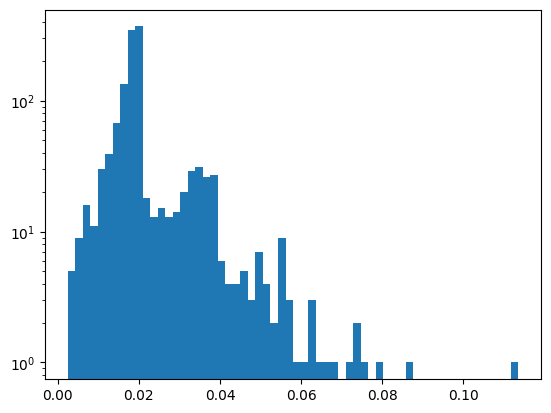

In [118]:
# 
columns = { name: [res[name] for res in results] for name in results[0].keys() }

# plt.hist(columns['MAP'], bins=60)
plt.hist(columns['f_score'], bins=60)
plt.yscale('log')
# plt.hist(columns['rank'], bins=25)
plt.show()

#### Trash

In [ ]:
# get test recipes and their ratings
i = 0
userdata_test = df_test.iloc[i]
rated_recipes_test = userdata_test['rated_recipes']
rating_list_test = userdata_test['rating_list']

for recipe_id, rating in zip(rated_recipes_test, rating_list_test):
    similar_users_who_rated = [ idx for idx, row in df_train.iterrows() if recipe_id in row['rated_recipes'] ]
    print(similar_users_who_rated)
    break

In [ ]:
# Create csr matrix
data, rows, cols = [], [], []
for i, (user_id, row) in enumerate(df_train.iterrows()):
    for recipe_id, rating in zip(row['rated_recipes'], row['rating_list']):
        user_IDX = id_to_index_USERS[user_id]
        recipe_IDX = id_to_index_RECIPES[recipe_id]
        data.append(rating)
        rows.append(user_IDX)
        cols.append(recipe_IDX)
user_item_matrix = csr_matrix((data, (rows, cols)), shape=(len(df_train), len(df_recipes)))

In [ ]:
user_item_matrix[0]
np.corrcoef([1,2,4,3], [1,2,2,3])[0][1]
i = 0
user_vector = user_item_matrix[i].toarray()
ccs = []
for j, sp_vector in enumerate(user_item_matrix):
    # vector = user_item_matrix[j].toarray()
    cc = np.corrcoef(user_vector, sp_vector.toarray())[0][1]
    ccs.append(cc)
ccs

In [ ]:
for i, vector in enumerate(user_item_matrix):
    print(vector.toarray())
    if i > 5: break